#### Classify model from Yu, et al
Implementation of the classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing)


In [1]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers

import os
import numpy as np
import pandas as pd
import pickle5 as pickle

import helpers as helper
import seaborn as sns
from sklearn.metrics import confusion_matrix

import time

In [10]:
# specify variables for model
#path = '../../data'
path = ''
filename = 'WM-clean-id224filter7'
option = '-clsaug' # -clsaug, -detund
map_column = 'filterMap7'
label_column = 'classifyLabels'
filetype = 'zip' # zip, pkl

model_id = 'yuclassify'
#result_path = '../../results'
result_path = ''
note = '-firstrun' # -optional

In [11]:
# load train, dev, and test sets

start = time.time()

if filetype == 'pkl':
    # open pkl files
    with open(f'{path}/{filename}-train{option}.pkl', "rb") as fh:
        train = pickle.load(fh)
    with open(f'{path}/{filename}-dev.pkl', "rb") as fh:
        dev = pickle.load(fh)
    with open(f'{path}/{filename}-test.pkl', "rb") as fh:
        test = pickle.load(fh)

elif filetype == 'zip':
    train = helper.load(f'{path}/{filename}-train{option}.zip')
    dev = helper.load(f'{path}/{filename}-dev.zip')
    test = helper.load(f'{path}/{filename}-test.zip')

# remove none type from dev and test sets
dev = dev[dev.failureType != 'none']
test = test[test.failureType != 'none']

print("Wall time: {} seconds".format(time.time() - start))
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

FileNotFoundError: [Errno 2] No such file or directory: '../../data/WM-clean-id224filter7-train-clsaug.zip'

#### Quick EDA

In [23]:
# baseline accuracy of test set
nones = len(test[test.failureType == 'Edge-Ring'])
total = len(test)
print(f"Baseline accuracy: {nones/total*100:.2f}%")

Baseline accuracy: 37.93%


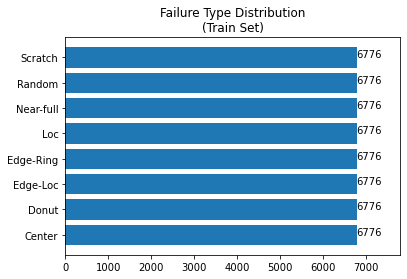

In [5]:
# train failure type distribution
helper.defect_distribution(train, note='Train Set')

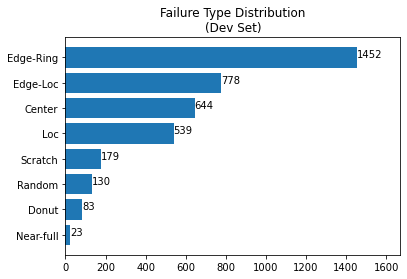

In [6]:
# dev failure type distribution
helper.defect_distribution(dev, note='Dev Set')

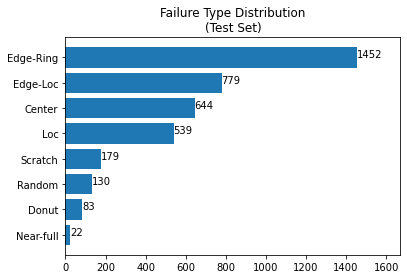

In [7]:
# test failure type distribution
helper.defect_distribution(test, note='Test Set')

#### Data set-up

In [8]:
# prepare inputs
x_train = np.stack(train[map_column])
x_val = np.stack(dev[map_column])
x_test = np.stack(test[map_column])

# sanity check
# expected: (#rows, xdim, ydim)
x_train.shape

(54208, 224, 224)

In [9]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)

# sanity check
# expected: TensorShape([#rows, xdim, ydim, 1])
x_train.shape

TensorShape([54208, 224, 224, 1])

In [10]:
# prepare labels for supervised learning
# note: make sure labels are integers if using sparse categorical cross entropy
y_train = np.asarray(train[label_column]).astype('int64')
y_val = np.asarray(dev[label_column]).astype('int64')
y_test = np.asarray(test[label_column]).astype('int64')

# subtract 1 from labels to agree with model
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

# sanity check
print(type(y_train[0]))
print(min(y_train))
print(max(y_train))

<class 'numpy.int64'>
0
7


#### Model

In [11]:
# define model architecture
model = models.Sequential()
model.add(layers.Conv2D(32, 3, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model.add(layers.MaxPooling2D(3))
model.add(layers.Flatten())
model.add(layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001)))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 128)       7

In [12]:
# set model optimizer and metrics
opt = optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [13]:
# run model
history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
424/424 [==============================] - 2276s 5s/step - loss: 1.0564 - accuracy: 0.6311 - val_loss: 0.3306 - val_accuracy: 0.8788
Epoch 2/20
424/424 [==============================] - 2209s 5s/step - loss: 0.3358 - accuracy: 0.8840 - val_loss: 0.2501 - val_accuracy: 0.9141
Epoch 3/20
424/424 [==============================] - 2191s 5s/step - loss: 0.2828 - accuracy: 0.9070 - val_loss: 0.2303 - val_accuracy: 0.9227
Epoch 4/20
424/424 [==============================] - 2191s 5s/step - loss: 0.2379 - accuracy: 0.9245 - val_loss: 0.2462 - val_accuracy: 0.9245
Epoch 5/20
424/424 [==============================] - 2267s 5s/step - loss: 0.2227 - accuracy: 0.9329 - val_loss: 0.2141 - val_accuracy: 0.9347
Epoch 6/20
424/424 [==============================] - 2517s 6s/step - loss: 0.1992 - accuracy: 0.9422 - val_loss: 0.2220 - val_accuracy: 0.9350
Epoch 7/20
424/424 [==============================] - 2451s 6s/step - loss: 0.1870 - accuracy: 0.9478 - val_loss: 0.2243 - val_accuracy:

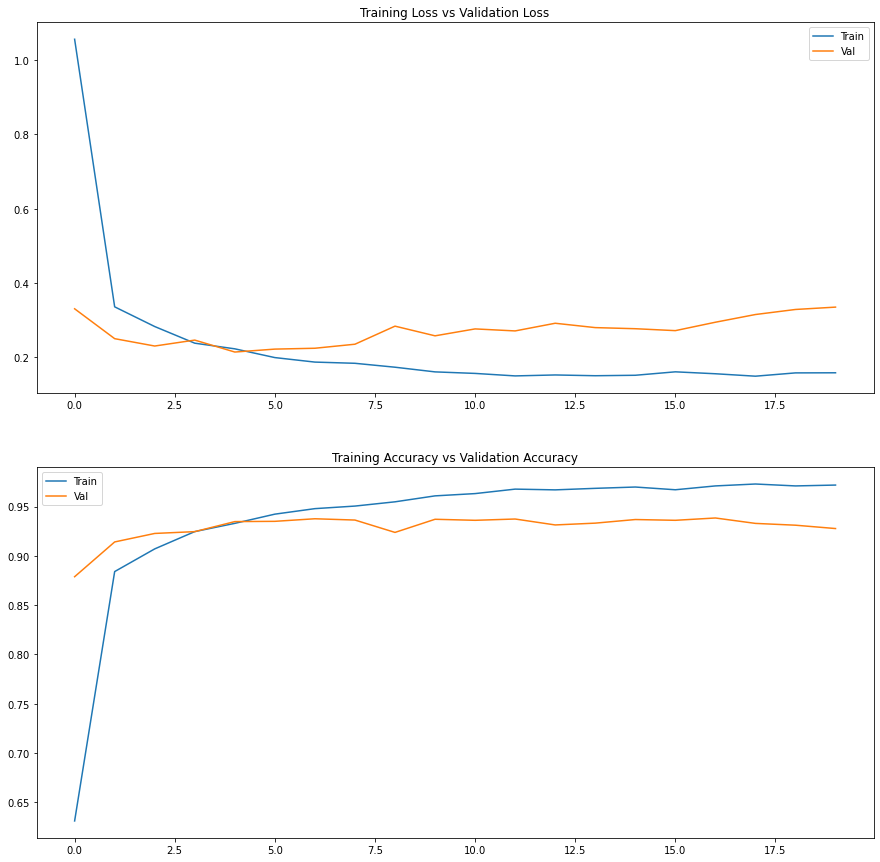

In [14]:
# visualize accuracy and loss history
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])

#### Model results

In [15]:
# compute model results on test set
start = time.time()
results = model.evaluate(x_test, y_test)
print("Wall time: {} seconds".format(time.time() - start))
print(results)

120/120 [==============================] - 41s 344ms/step - loss: 0.3269 - accuracy: 0.9242
Wall time: 41.60411500930786 seconds
[0.3268814980983734, 0.9242424368858337]


In [16]:
# generate predictions for model analysis
start = time.time()
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
print("Wall time: {} seconds".format(time.time() - start))

Wall time: 38.99683117866516 seconds


In [20]:
# save results, history, and predictions
with open(f'../../results/{model_id}-{filename}{option}{note}.pkl', "wb") as f:
    pickle.dump(y_pred, f)

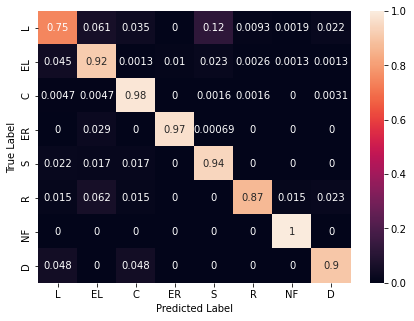

In [21]:
# plot confusion matrix
helper.plot_confusion_matrix(y_test, y_pred, normalize=True)

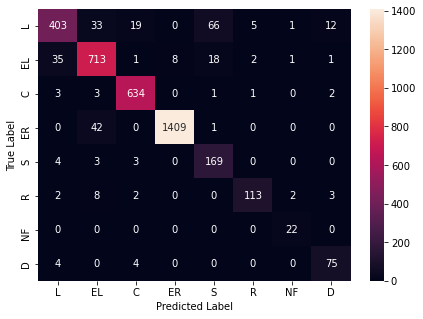

In [22]:
helper.plot_confusion_matrix(y_test, y_pred, normalize=False)